
# VN Jobs 2024 — End‑to‑End: Làm sạch • Trực quan • Prophet • ML

**Mục tiêu:** Gom toàn bộ pipeline vào một notebook: làm sạch & chuẩn hoá, EDA, Prophet (nếu có cột ngày), và mô hình dự đoán lương.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_colwidth", 300)
DATA_PATH = Path("C:/Users/Lapto/JobsTrending/datasets/short_jobs/train.csv")
print("Using data file:", DATA_PATH.resolve())


Using data file: C:\Users\Lapto\JobsTrending\datasets\short_jobs\train.csv


In [16]:

# Đọc dữ liệu (thử nhiều encoding)
encodings_to_try = ["utf-8", "utf-8-sig", "cp1258", "cp1252"]
df = None
last_err = None
for enc in encodings_to_try:
    try:
        df = pd.read_csv(DATA_PATH, encoding=enc, low_memory=False)
        print("Read with encoding:", enc, "| shape:", df.shape)
        break
    except Exception as e:
        last_err = e

if df is None:
    raise RuntimeError(f"Không thể đọc CSV. Lỗi cuối: {last_err}")

print("Columns:", list(df.columns))
df.head(5)

Read with encoding: utf-8 | shape: (68376, 12)
Columns: ['job_title', 'job_type', 'position_level', 'city', 'experience', 'skills', 'job_fields', 'salary', 'salary_min', 'salary_max', 'unit', 'info']


,job_title,job_type,position_level,city,experience,skills,job_fields,salary,salary_min,salary_max,unit,info
0,chuyên viên chăm sóc khách hàng cao cấp mảng thời trang hàng hiệu,full-time,"nhân viên, chuyên viên",hà nội,1 - 3 năm,"thời trang, tư vấn bán hàng","marketing, bán hàng, chăm sóc khách hàng, kinh doanh",đến 20 triệu vnđ,0.0,20.0,vnd,"công việc: chuyên viên chăm sóc khách hàng cao cấp mảng thời trang hàng hiệu. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: 1 - 3 năm - địa điểm làm việc: hà nội -kỹ năng: thời trang, tư vấn bán hàng - lĩnh vực: marketing, bán hàng, chăm sóc khách hàng, kinh doanh"
1,nhân viên content creator,full-time,"nhân viên, chuyên viên",hồ chí minh,trên 2 năm,"dựng phim, hiệu ứng video, nội dung, digital marketing","dược phẩm, marketing, spa, làm đẹp, mỹ phẩm",13 - 18 triệu vnđ,13.0,18.0,vnd,"công việc: nhân viên content creator. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: trên 2 năm - địa điểm làm việc: hồ chí minh -kỹ năng: dựng phim, hiệu ứng video, nội dung, digital marketing - lĩnh vực: dược phẩm, marketing, spa, làm đẹp, mỹ phẩm"
2,sale markerting,full-time,"nhân viên, chuyên viên",hồ chí minh,không yêu cầu,"tư vấn doanh nghiệp (b2b), social marketing, nội dung","truyền thông, chăm sóc khách hàng, marketing, quảng cáo, pr",8 - 10 triệu vnđ,8.0,10.0,vnd,"công việc: sale markerting. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: không yêu cầu - địa điểm làm việc: hồ chí minh -kỹ năng: tư vấn doanh nghiệp (b2b), social marketing, nội dung - lĩnh vực: truyền thông, chăm sóc khách hàng, marketing, quảng cáo, pr"
3,giám sát bán hàng,full-time,"trưởng nhóm, trưởng phòng",đà nẵng,trên 1 năm,tư vấn bán hàng,NaN,10 - 15 triệu vnđ,10.0,15.0,vnd,"công việc: giám sát bán hàng. hình thức làm việc: full-time - chức vụ: trưởng nhóm, trưởng phòng - kinh nghiệm: trên 1 năm - địa điểm làm việc: đà nẵng -kỹ năng: tư vấn bán hàng - lĩnh vực: nan"
4,nhân viên thủ kho vật tư công trường,toàn thời gian cố định,"chuyên viên, nhân viên",đồng nai,không yêu cầu,", kế toán, thu mua kho vận chuỗi cung ứng, xây dựng",", kế toán, thu mua - kho vận - chuỗi cung ứng, xây dựng",12 - 15 triệu,12.0,15.0,vnd,"công việc: nhân viên thủ kho vật tư công trường. hình thức làm việc: toàn thời gian cố định - chức vụ: chuyên viên, nhân viên - kinh nghiệm: không yêu cầu - địa điểm làm việc: đồng nai -kỹ năng: , kế toán, thu mua kho vận chuỗi cung ứng, xây dựng - lĩnh vực: , kế toán, thu mua - kho vận - chuỗi ..."


In [17]:

# Helpers + hằng số
def normalize_text(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True)

def parse_years(exp: str) -> float:
    import re
    if not isinstance(exp, str) or exp.strip()=="" or "không yêu cầu" in exp:
        return 0.0
    nums = re.findall(r"\d+\.?\d*", exp)
    if not nums:
        return np.nan
    return float(nums[0])

USD_TO_MILLION_VND = 0.025  # 1 USD ~ 0.025 triệu VND


In [18]:

# Làm sạch & chuẩn hoá
for c in ["job_title","job_type","position_level","city","experience","skills","job_fields","unit"]:
    if c in df.columns:
        df[c] = normalize_text(df[c])

for c in ["salary_min","salary_max"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "unit" in df.columns:
    usd_mask = df["unit"].fillna("").str.contains("usd", case=False)
else:
    usd_mask = pd.Series(False, index=df.index)

df.loc[usd_mask, "salary_min"] = df.loc[usd_mask, "salary_min"] * USD_TO_MILLION_VND
df.loc[usd_mask, "salary_max"] = df.loc[usd_mask, "salary_max"] * USD_TO_MILLION_VND

df["salary_min"] = df["salary_min"].clip(lower=0.1)
df["salary_max"] = df[["salary_max","salary_min"]].max(axis=1).clip(lower=0.1)
df["salary_mid"] = df[["salary_min","salary_max"]].mean(axis=1)

if "experience" in df.columns:
    df["experience_years"] = df["experience"].apply(parse_years)
else:
    df["experience_years"] = np.nan

if "skills" in df.columns:
    df["skills_count"] = df["skills"].fillna("").apply(lambda s: len([x.strip() for x in str(s).split(",") if x.strip()!='']))
else:
    df["skills_count"] = np.nan

df.head(3)

,job_title,job_type,position_level,city,experience,skills,job_fields,salary,salary_min,salary_max,unit,info,salary_mid,experience_years,skills_count
0,chuyên viên chăm sóc khách hàng cao cấp mảng thời trang hàng hiệu,full-time,"nhân viên, chuyên viên",hà nội,1 - 3 năm,"thời trang, tư vấn bán hàng","marketing, bán hàng, chăm sóc khách hàng, kinh doanh",đến 20 triệu vnđ,0.1,20.0,vnd,"công việc: chuyên viên chăm sóc khách hàng cao cấp mảng thời trang hàng hiệu. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: 1 - 3 năm - địa điểm làm việc: hà nội -kỹ năng: thời trang, tư vấn bán hàng - lĩnh vực: marketing, bán hàng, chăm sóc khách hàng, kinh doanh",10.05,1.0,2
1,nhân viên content creator,full-time,"nhân viên, chuyên viên",hồ chí minh,trên 2 năm,"dựng phim, hiệu ứng video, nội dung, digital marketing","dược phẩm, marketing, spa, làm đẹp, mỹ phẩm",13 - 18 triệu vnđ,13.0,18.0,vnd,"công việc: nhân viên content creator. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: trên 2 năm - địa điểm làm việc: hồ chí minh -kỹ năng: dựng phim, hiệu ứng video, nội dung, digital marketing - lĩnh vực: dược phẩm, marketing, spa, làm đẹp, mỹ phẩm",15.50,2.0,4
2,sale markerting,full-time,"nhân viên, chuyên viên",hồ chí minh,không yêu cầu,"tư vấn doanh nghiệp (b2b), social marketing, nội dung","truyền thông, chăm sóc khách hàng, marketing, quảng cáo, pr",8 - 10 triệu vnđ,8.0,10.0,vnd,"công việc: sale markerting. hình thức làm việc: full-time - chức vụ: nhân viên, chuyên viên - kinh nghiệm: không yêu cầu - địa điểm làm việc: hồ chí minh -kỹ năng: tư vấn doanh nghiệp (b2b), social marketing, nội dung - lĩnh vực: truyền thông, chăm sóc khách hàng, marketing, quảng cáo, pr",9.00,0.0,3


In [19]:

# Lưu dữ liệu sạch
out_clean = Path("clean_jobs.csv")
df.to_csv(out_clean, index=False, encoding="utf-8")
print("Đã lưu:", out_clean.resolve())
df[["salary_min","salary_max","salary_mid"]].describe()

Đã lưu: D:\Kỳ 1_2025_2026\Chuyen_doi_so\project\project\clean_jobs.csv


,salary_min,salary_max,salary_mid
count,68376.000000,68376.000000,68376.000000
mean,11.648866,19.702907,15.675886
std,14.888194,19.649597,16.359779
min,0.100000,0.100000,0.100000
25%,8.000000,12.000000,10.050000
50%,10.000000,15.000000,13.000000
75%,14.000000,21.000000,17.500000
max,900.000000,900.000000,900.000000


## Trực quan — Top thành phố theo số tin đăng

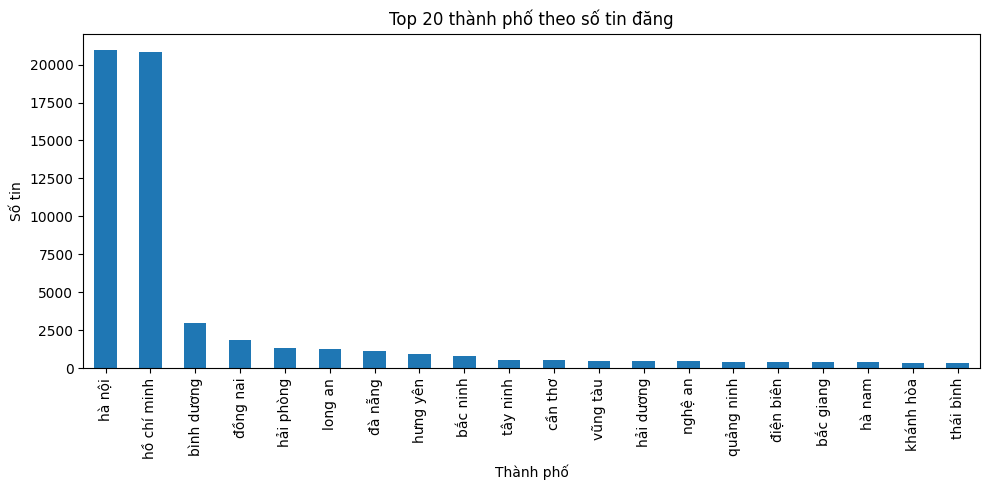

In [20]:

if "city" in df.columns:
    top_city = df["city"].value_counts().head(20)
    plt.figure(figsize=(10,5))
    top_city.plot(kind="bar")
    plt.title("Top 20 thành phố theo số tin đăng")
    plt.xlabel("Thành phố")
    plt.ylabel("Số tin")
    plt.tight_layout()
    plt.show()
else:
    print("Không có cột 'city'.")

## Trực quan — Phân phối lương (triệu VND/tháng)

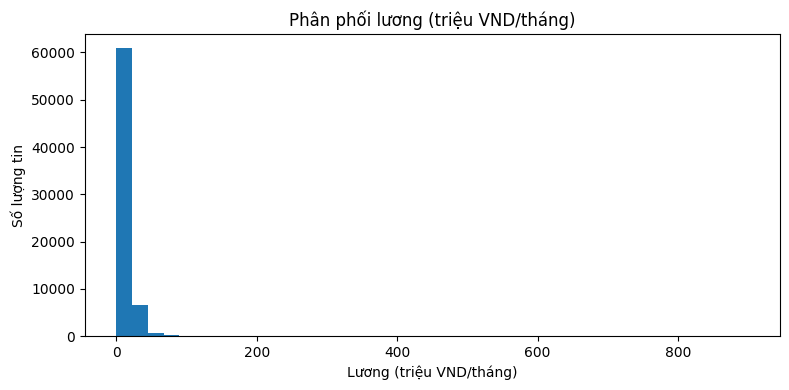

In [21]:

if "salary_mid" in df.columns:
    vals = df["salary_mid"].dropna().values
    if len(vals) > 0:
        plt.figure(figsize=(8,4))
        plt.hist(vals, bins=40)
        plt.title("Phân phối lương (triệu VND/tháng)")
        plt.xlabel("Lương (triệu VND/tháng)")
        plt.ylabel("Số lượng tin")
        plt.tight_layout()
        plt.show()
    else:
        print("Không có salary_mid hợp lệ.")
else:
    print("Không có cột 'salary_mid'.")

## (Tuỳ chọn) Prophet — Dự báo số tin đăng 90 ngày

In [22]:

# Dò cột ngày
date_col = None
for c in df.columns:
    lc = c.lower()
    if any(k in lc for k in ["date","posted","time","created"]):
        date_col = c
        break

if date_col is None:
    print("Chưa phát hiện cột thời gian. Bỏ qua Prophet.")
else:
    print("Sử dụng cột ngày:", date_col)
    try:
        from prophet import Prophet
        ts = df[[date_col]].copy()
        ts[date_col] = pd.to_datetime(ts[date_col], errors="coerce")
        ts = ts.dropna()
        if len(ts)==0:
            print("Không có ngày hợp lệ sau chuyển đổi.")
        else:
            ts["ds"] = ts[date_col]
            ts["y"] = 1
            ts = ts.groupby("ds").agg(y=("y","sum")).reset_index()
            m = Prophet()
            m.fit(ts)
            future = m.make_future_dataframe(periods=90)
            fcst = m.predict(future)
            plt.figure(figsize=(10,4))
            plt.plot(fcst["ds"], fcst["yhat"])
            plt.title("Dự báo số tin đăng (Prophet) — yhat")
            plt.xlabel("Ngày")
            plt.ylabel("Số tin (ước lượng)")
            plt.tight_layout()
            plt.show()
            fcst.tail(10)
    except Exception as e:
        print("Không chạy được Prophet. Hãy cài 'prophet'. Lý do:", e)

Chưa phát hiện cột thời gian. Bỏ qua Prophet.


## Mô hình dự đoán lương — RandomForest

In [ ]:
# ==== CLEAN TARGET + ROBUST REGRESSION ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import shuffle
import joblib, json, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

target_col = "salary_mid"

# 1) Kiểm tra đơn vị: nếu hiện đang là VND, hãy đổi về **triệu VND/tháng** trước khi train
# ví dụ: df[target_col] = df[target_col] / 1_000_000

y_raw = pd.to_numeric(df[target_col], errors="coerce")

# 2) Lọc các giá trị xấu & outlier
mask_valid = y_raw.notna() & (y_raw > 0)
y1 = y_raw.loc[mask_valid]

q1, q99 = y1.quantile(0.01), y1.quantile(0.99)
mask_iqr = (y_raw >= q1) & (y_raw <= q99)

mask = mask_valid & mask_iqr
y = y_raw.loc[mask].copy()

# 3) Chuẩn bị X
text_cols = [c for c in ["job_title","skills","job_fields","info"] if c in df.columns]
cat_cols  = [c for c in ["city","position_level","job_type"] if c in df.columns]
num_cols  = [c for c in ["experience_years","skills_count","salary_min","salary_max"] if c in df.columns]

X = df.loc[mask, text_cols + cat_cols + num_cols].copy()

if text_cols:
    X["text_merged"] = X[text_cols].fillna("").agg(" ".join, axis=1)
else:
    X["text_merged"] = ""

for c in cat_cols:
    X[c] = X[c].fillna("na").astype(str)
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0)

# (tùy chọn) giảm mẫu để train nhanh
MAX_ROWS = 150_000
if len(X) > MAX_ROWS:
    X, y = shuffle(X, y, random_state=42)
    X, y = X.iloc[:MAX_ROWS].copy(), y.iloc[:MAX_ROWS].copy()
    print(f"Downsample còn {len(X):,} dòng")

# 4) Log-transform mục tiêu
y_log = np.log1p(y)

# 5) Pipeline
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
    [
        ("text", TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3, max_df=0.6), "text_merged"),
        *([("cat", ohe, cat_cols)] if cat_cols else []),
        *([("num", "passthrough", num_cols)] if num_cols else []),
    ],
    remainder="drop",
)

sgd = SGDRegressor(
    loss="huber",             # robust với outlier
    epsilon=1.35,
    penalty="l2",
    alpha=1e-4,
    learning_rate="adaptive", # ổn định hơn
    eta0=0.05,
    max_iter=3000,
    tol=1e-3,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42,
)

model = Pipeline([("prep", preprocess), ("sgd", sgd)])

X_train, X_test, ytr, yte = train_test_split(X, y_log, test_size=0.2, random_state=42)
model.fit(X_train, ytr)

# 6) Đánh giá trên thang gốc
pred_log = model.predict(X_test)
pred = np.expm1(pred_log)          # đảo log1p
y_true = np.expm1(yte)

mae = float(mean_absolute_error(y_true, pred))
r2  = float(r2_score(y_true, pred))
print("MAE (triệu VND):", round(mae, 2))
print("R²:", round(r2, 3))

# 7) Lưu
joblib.dump(model, "salary_model.joblib")
with open("feature_spec.json", "w", encoding="utf-8") as f:
    json.dump({
        "text_cols": text_cols,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "target": target_col,
        "unit": "triệu VND/tháng",
        "MAE": mae,
        "R2": r2,
        "model": "TFIDF+SGDRegressor(huber, log-target)"
    }, f, ensure_ascii=False, indent=2)

print("Đã lưu: salary_model.joblib, feature_spec.json")


MAE (triệu VND): 14888207093.3
R²: -2.0214958428311433e+19
Đã lưu: salary_model.joblib, feature_spec.json
